In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from analysis_helpers import poisson_waiting_function, \
                            run_multiple_trajectories, \
                            plot_aip_vs_t, \
                            plot_cip_vs_t, \
                            run_sensitivity_sims, \
                            extract_cips, \
                            load_sim_dir
recall_no_testing = load_sim_dir("/nfs01/covid_sims/contact_recall_fall_slightly_pessimistic.1590264282.86")
recall_testing = load_sim_dir("/nfs01/covid_sims/contact_recall_fall_slightly_pessimistic_testing.1590264282.86")

done loading contact_tracing_constant.0.0
done loading contact_tracing_constant.0.1
done loading contact_tracing_constant.0.2
done loading contact_tracing_constant.0.3
done loading contact_tracing_constant.0.4
done loading contact_tracing_constant.0.5
done loading contact_tracing_constant.0.6
done loading contact_tracing_constant.0.7
done loading contact_tracing_constant.0.8
done loading contact_tracing_constant.0.9
done loading contact_tracing_constant.1
done loading contact_tracing_constant.0.0
done loading contact_tracing_constant.0.1
done loading contact_tracing_constant.0.2
done loading contact_tracing_constant.0.3
done loading contact_tracing_constant.0.4
done loading contact_tracing_constant.0.5
done loading contact_tracing_constant.0.6
done loading contact_tracing_constant.0.7
done loading contact_tracing_constant.0.8
done loading contact_tracing_constant.0.9
done loading contact_tracing_constant.1


In [2]:
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
def extract_severities(dfs):
    severities = []
    for df in dfs:
        all_cols = set(df.columns)
        new_cols = set(['cumulative_mild', 
                        'cumulative_severe', 
                        'severity_0', 
                        'severity_1', 
                        'severity_2', 
                        'severity_3'])
        main_cols = all_cols - new_cols
        subdf = df[list(main_cols)]
        popsize = sum(subdf.iloc[0])
        
        subdf = df[['severity_2', 'severity_3']]
        severe = sum(subdf.iloc[subdf.shape[0]-1])
        
        severities.append(100 * severe / popsize)
    return severities
def average_cumulative_severe(dfs):
    severities = []
    for df in dfs:
        all_cols = set(df.columns)
        new_cols = set(['cumulative_mild', 
                        'cumulative_severe', 
                        'severity_0', 
                        'severity_1', 
                        'severity_2', 
                        'severity_3'])
        main_cols = all_cols - new_cols
        subdf = df[list(main_cols)]
        popsize = sum(subdf.iloc[0])
        
        subdf = df[['severity_2', 'severity_3']]
        severe = sum(subdf.iloc[subdf.shape[0]-1])
        
        severities.append(100 * severe / popsize)
    return np.mean(severities)

def avg_cum_severe_quantile(dfs, q_low, q_high):
    severities = extract_severities(dfs)
    return np.quantile(severities, q_low), np.mean(severities), np.quantile(severities, q_high)

def cum_severe_quantiles(dfs, q_low, q_high):
    severities = extract_severities(dfs)
    return np.quantile(severities, q_low), np.quantile(severities, 0.5), np.quantile(severities, q_high)

def plot_many_dfs(sim_output_dict, yaxisfn, ylabel="", xlabel="", title="", figsize=(10,6)):
    plt.figure(figsize=figsize)
    for sim_label, sim_output in sim_output_dict.items():
        xs = []
        ys = []
        for sim_parameter_name, dfs in sim_output.items():
            # compute x-value assuming that sim_param_name is of form 'varied_param_name.value'
            param_val = float('.'.join(sim_parameter_name.split('.')[1:]))
            xs.append(param_val)
            # yaxisfn is a function that takes in a list of trajectory dataframes and
            # produces an output metric
            ys.append(yaxisfn(dfs))
        plt.plot(xs, ys, marker='o', label=sim_label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.show()


def truncate(val, y_min, y_max):
    return max(min(val, y_max), y_min)
    
def plot_many_dfs_quantiles(sim_output_dict, yaxisfn, normalize_x_axis, x_log_scale=False, 
                            y_log_scale=False,
                            q_low=0.05, q_high=0.95, 
                            y_min = 0, y_max = 5,
                            ylabel="", xlabel="", title="", figsize=(10,6), alpha=0.1, color=None, savefig_name = None):
    # assn: yaxisfn(dfs) returns a tuple (q_low_val, avg, q_high_val)
    epsilon=1e-6
    plt.figure(figsize=figsize)
    if x_log_scale:
        plt.xscale("log")
    if y_log_scale:
        plt.yscale("log")
        #_, _, ymin, _ = plt.axis()
        #plt.ylim(bottom=max(1e-2, ymin))
    else:
        plt.ylim(y_min, y_max)
    
    for sim_label, sim_output in sim_output_dict.items():
        xs = []
        ys = []
        q_low_vals = []
        q_high_vals = []
        for sim_parameter_name, dfs in sim_output.items():
            # compute x-value assuming that sim_param_name is of form 'varied_param_name.value'
            param_val = float('.'.join(sim_parameter_name.split('.')[1:]))
            if normalize_x_axis:
                xs.append(param_val * 100)
            else:
                xs.append(param_val)
            # yaxisfn is a function that takes in a list of trajectory dataframes and
            # produces an output metric
            q_low_val, avg, q_high_val = yaxisfn(dfs, q_low, q_high)
            if not y_log_scale:
                ys.append(truncate(avg, y_min, y_max))
                q_low_vals.append(truncate(q_low_val, y_min, y_max))
                q_high_vals.append(truncate(q_high_val, y_min, y_max))
            else:
                ys.append(avg + epsilon)
                q_low_vals.append(q_low_val + epsilon)
                q_high_vals.append(q_high_val + epsilon)
        if color == None:
            plt.plot(xs, ys, marker='o', label=sim_label)
            plt.fill_between(xs, q_low_vals, q_high_vals, alpha=alpha)
        else:
            plt.plot(xs, ys, marker='o', label=sim_label, color=color)
            plt.fill_between(xs, q_low_vals, q_high_vals, alpha=alpha, color=color)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    if savefig_name:
        plt.savefig("/nfs01/covid_figs/" + savefig_name + ".pdf")
    
    
    
    plt.show()

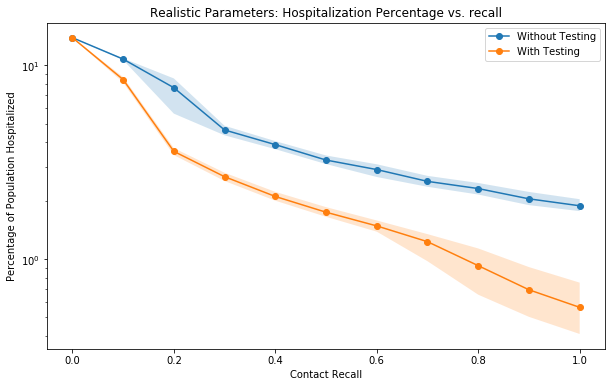

In [3]:
plot_many_dfs_quantiles({'Without Testing': recall_no_testing, 
                             'With Testing': recall_testing}, 
                            cum_severe_quantiles,
                            False, x_log_scale=False,
                     xlabel="Contact Recall", ylabel="Percentage of Population Hospitalized",
                     title="Realistic Parameters: Hospitalization Percentage vs. recall", 
                               q_low=0.1, q_high=0.9, alpha=0.2, y_min = 0, y_max=5, y_log_scale=True)

In [4]:

recall_no_testing = load_sim_dir("/nfs01/covid_sims/contact_delay_fall_slightly_pessimistic.1590267780.56")
recall_testing = load_sim_dir("/nfs01/covid_sims/contact_delay_fall_slightly_pessimistic_testing.1590267780.57")

done loading contact_tracing_delay.0
done loading contact_tracing_delay.1
done loading contact_tracing_delay.2
done loading contact_tracing_delay.3
done loading contact_tracing_delay.4
done loading contact_tracing_delay.5
done loading contact_tracing_delay.6
done loading contact_tracing_delay.7
done loading contact_tracing_delay.0
done loading contact_tracing_delay.1
done loading contact_tracing_delay.2
done loading contact_tracing_delay.3
done loading contact_tracing_delay.4
done loading contact_tracing_delay.5
done loading contact_tracing_delay.6
done loading contact_tracing_delay.7


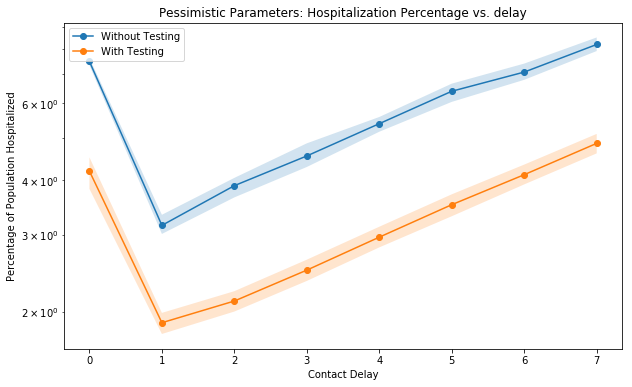

In [6]:
plot_many_dfs_quantiles({'Without Testing': recall_no_testing, 
                             'With Testing': recall_testing}, 
                            cum_severe_quantiles,
                            False, x_log_scale=False,
                     xlabel="Contact Delay", ylabel="Percentage of Population Hospitalized",
                     title="Pessimistic Parameters: Hospitalization Percentage vs. delay", 
                               q_low=0.1, q_high=0.9, alpha=0.2, y_min = 0, y_max=5, y_log_scale=True)